### 統計學習與深度學習
### Homework 5

#### 姓名：黃瀚陞 學號：R09725060

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

這個作業將要練習影像分類的問題。影像分類是CNN模型的強項，我們的任務是區分照片中主角穿的上衣類型。這個問題在不同的情境下有不同的難度。在`Dive into Deep Learning`中有類似的問題，但是處理較"乾淨"的影像。這次作業的資料來自街拍影像，因此分類的困難度較高。

我們這次作業的任務，是依照照片中人物的上衣，區分以下類別:
* blazer
* cardigan
* coat
* jacket

下面列出這四個類別的範例訓練資料。

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive') 
os.listdir()

Mounted at /content/drive


['Shareddrives',
 '.shortcut-targets-by-id',
 'MyDrive',
 '.file-revisions-by-id',
 '.Trash-0']

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tqdm import tqdm
import copy
from sklearn.metrics import confusion_matrix
import pandas as pd


Label =  blazer


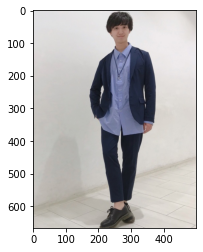

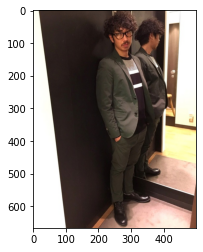

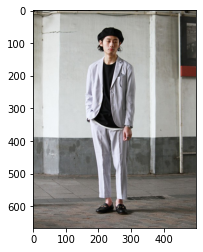

Label =  cardigan


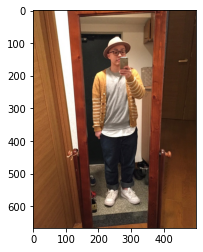

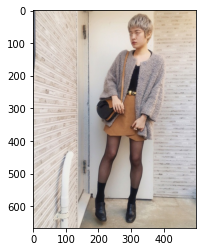

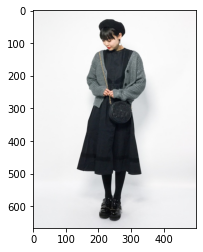

Label =  coat


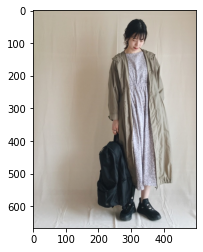

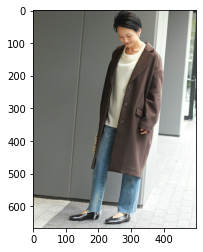

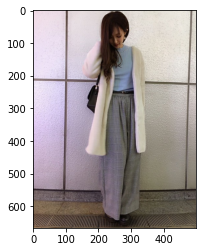

Label =  jacket


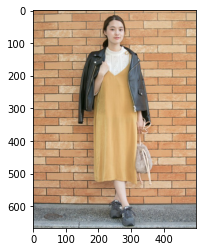

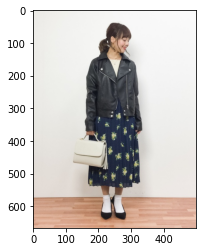

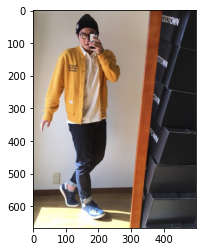

In [3]:
random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("/content/drive/Shareddrives/SLDL/photos/train/", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

### 資料
資料在`photos`資料夾。已經區分好訓練(train)、校正(valid)、測試(test)資料。下一層則是依照圖片的標籤分資料夾存放，因此有四個資料夾，分別是blazer, cardigan, coat, jacket。一張圖片只會屬於一個類別。

### Q1
(5%) 列出train, valid, test的總照片數，以及各類別的照片數與比率。在還沒進行模型訓練與評估前，你認為各類別相對的準確率的大小關係為何?

In [4]:
folder=['train','valid','test']
data_num=[]

for i in range(len(folder)):
    temp_list=[]
    for j in range(len(labels)):
        basepath = os.path.join("/content/drive/Shareddrives/SLDL/photos/", folder[i], labels[j], "*.jpg")
        cand_fn = glob.glob(basepath)
        temp_list.append(len(cand_fn))
        print(labels[j], "in", folder[i], len(cand_fn))
    data_num.append(temp_list)
    
photo_num=0
for i in range(len(folder)):
    photo_num+=sum(data_num[i])
print("Total Number of Dataset:",photo_num,"\n")
print("Splitting:")
for i in range(len(folder)):
    print("Number of",folder[i],sum(data_num[i]),"( Proportion:",round(sum(data_num[i])/photo_num,2),")")
print("\nLabels:")
for i in range(len(labels)):
    count=0
    for j in range(len(folder)):
        count+=data_num[j][i]
    print("Number of",labels[i],count,"( Proportion:",round(count/photo_num,2),")")

blazer in train 97
cardigan in train 237
coat in train 296
jacket in train 411
blazer in valid 7
cardigan in valid 36
coat in valid 27
jacket in valid 35
blazer in test 9
cardigan in test 42
coat in test 43
jacket in test 52
Total Number of Dataset: 1292 

Splitting:
Number of train 1041 ( Proportion: 0.81 )
Number of valid 105 ( Proportion: 0.08 )
Number of test 146 ( Proportion: 0.11 )

Labels:
Number of blazer 113 ( Proportion: 0.09 )
Number of cardigan 315 ( Proportion: 0.24 )
Number of coat 366 ( Proportion: 0.28 )
Number of jacket 498 ( Proportion: 0.39 )


Q1 解釋：  
類別的照片數與比例如上輸出所示。  
我認為準確率的大小應該會是jacket>coat≒cardigan>blazer。從比例上來看，blazer這個類別僅佔了總資料不到一成，資料量相對於其他類別是少很多，即使全部的blazer都猜錯，對於整體的準確率影響也相對其他類別來得小，所以我推測blazer應該會是準確率最低的類別。相對來說，jacket類別的資料不論是在整體、train、valid或是test都是最多，所以jacket最後的準確率應該會最高。而cardigan與coat的資料量差不多，準確率也差不多，並且準確率應該介於jacket和blazer之間。

### Q2
(35%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。使用train資料訓練模型，以valid資料決定Early Stopping的Epoch。Early Stopping的Patient參數設為20 Epochs。Batch size設為32。每一個Epoch計算一次Valid Loss，並記錄Valid Loss最低的模型。模型訓練最多200個Epochs。使用最佳模型在test資料計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的Valid Loss。

由於圖片的解析度較高，模型訓練前須將解析度調整(Resize)成較短邊為256像素的照片，然後隨機取大小為224x224的影像。接著隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度，並依照Pretrained ResNet的要求調整RGB的均數與標準差。
測試資料(Valid and Test)亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

得到Per-Class Accuracy之後，請討論與Q1預期的差異與可能原因。

提示: 
* Pytorch Resnet pretrained model的說明請見 <https://pytorch.org/hub/pytorch_vision_resnet/>
* 本題的Test Accuracy應高於78%。

In [5]:
def training(net):
  
  print("Start training...")
  best_net = copy.deepcopy(net)
  n_epochs = 200
  validation_minloss = 999999
  earlystop_waiting = 0

  for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    earlystop_waiting += 1
    
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
      targets = targets.reshape((-1,))
      net.train()
      inputs = inputs.cuda()
      targets = targets.cuda()
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = loss_fn(outputs, targets)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()

    # Validation
    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(validloader):
        targets = targets.reshape((-1,))
        inputs = inputs.cuda()
        targets = targets.cuda()
        outputs = net(inputs) 
        loss = loss_fn(outputs, targets)
        valid_loss += loss.item()

    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    print("Epoch %d: Subtrain_Loss = %.3f Validation_Loss = %.3f" % (epoch, train_loss, valid_loss))

    if valid_loss <= validation_minloss:
      print("Validation loss decreased. Update the best net.")
      best_net=copy.deepcopy(net)
      validation_minloss = valid_loss
      earlystop_waiting = 0
    
    if earlystop_waiting >= 20:
      print("Early stop at epoch", epoch)
      break;

  return best_net

In [6]:
def testing(best_net):
  test_nobs = 0
  ncorrect = 0
  test_loss = 0.0
  all_pred=[]
  all_target=[]

  with torch.no_grad():
    best_net.eval()
    for batch_idx, (inputs, targets) in enumerate(testloader):
      targets = targets.reshape((-1,))
      inputs = inputs.cpu()
      targets = targets.cpu()
      best_net = best_net.cpu()
      outputs = best_net(inputs) 
      loss = loss_fn(outputs, targets)
      test_loss += loss.item()
      pred = (outputs.numpy().argmax(axis=1)).astype('float32')
      all_pred.extend(pred)
      all_target.extend(targets.numpy())
      tmp_correct = (pred == targets.numpy()).sum()
      ncorrect += tmp_correct
      test_nobs += len(pred)

  test_loss=test_loss/len(testloader)
  accuracy = ncorrect / test_nobs
  print("\nOutcome")
  print("Total Test Loss = %.3f" % test_loss)
  print("Total Accuracy = %.3f" % accuracy)

  return all_pred, all_target

In [7]:
def generateoutcome(all_pred, all_target):
  
  cmtx = pd.DataFrame(
      confusion_matrix(all_target, all_pred), 
      index=["blazer(True)", "cardigan(True)", "coat(True)", "jacket(True)"], 
      columns=["blazer(Pred)", "cardigan(Pred)", "coat(Pred)", "jacket(Pred)"])
  
  print("\nConfusion Matrix")
  print(cmtx)

  print("\nPer-class Accuracy")
  for i in range(len(labels)):
    temp_acc = cmtx.iloc[i,i] / cmtx.iloc[i].sum()
    print("Accuracy of",labels[i], round(temp_acc,3))

In [8]:
train_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.RandomCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(20),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder('/content/drive/Shareddrives/SLDL/photos/train/', transform=train_transform)
valid_data = datasets.ImageFolder('/content/drive/Shareddrives/SLDL/photos/valid/', transform=test_transform)
test_data = datasets.ImageFolder('/content/drive/Shareddrives/SLDL/photos/test/', transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True, num_workers=0)

In [9]:
use_cuda = torch.cuda.is_available()
net = models.resnet50(pretrained = True)

net.fc = torch.nn.Linear(2048,4)

if use_cuda:
  net = net.cuda()

print(net)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

best_net = training(net)
all_target, all_pred = testing(best_net)
generateoutcome(all_target, all_pred) 

Start training...
Epoch 1: Subtrain_Loss = 1.327 Validation_Loss = 1.300
Validation loss decreased. Update the best net.
Epoch 2: Subtrain_Loss = 1.257 Validation_Loss = 1.244
Validation loss decreased. Update the best net.
Epoch 3: Subtrain_Loss = 1.237 Validation_Loss = 1.276
Epoch 4: Subtrain_Loss = 1.213 Validation_Loss = 1.225
Validation loss decreased. Update the best net.
Epoch 5: Subtrain_Loss = 1.208 Validation_Loss = 1.199
Validation loss decreased. Update the best net.
Epoch 6: Subtrain_Loss = 1.182 Validation_Loss = 1.194
Validation loss decreased. Update the best net.
Epoch 7: Subtrain_Loss = 1.163 Validation_Loss = 1.206
Epoch 8: Subtrain_Loss = 1.142 Validation_Loss = 1.169
Validation loss decreased. Update the best net.
Epoch 9: Subtrain_Loss = 1.132 Validation_Loss = 1.162
Validation loss decreased. Update the best net.
Epoch 10: Subtrain_Loss = 1.116 Validation_Loss = 1.138
Validation loss decreased. Update the best net.
Epoch 11: Subtrain_Loss = 1.100 Validation_Loss

In [11]:
use_cuda = torch.cuda.is_available()
net = models.resnet50(pretrained = True)
net.fc = torch.nn.Linear(2048,4)
if use_cuda:
  net = net.cuda()

# print(net)

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005, amsgrad=True)
loss_fn = torch.nn.CrossEntropyLoss()

best_net = training(net)
all_target, all_pred = testing(best_net)
generateoutcome(all_target, all_pred)

Start training...
Epoch 1: Subtrain_Loss = 1.191 Validation_Loss = 1.043
Validation loss decreased. Update the best net.
Epoch 2: Subtrain_Loss = 0.811 Validation_Loss = 0.784
Validation loss decreased. Update the best net.
Epoch 3: Subtrain_Loss = 0.547 Validation_Loss = 0.695
Validation loss decreased. Update the best net.
Epoch 4: Subtrain_Loss = 0.385 Validation_Loss = 0.740
Epoch 5: Subtrain_Loss = 0.256 Validation_Loss = 0.720
Epoch 6: Subtrain_Loss = 0.186 Validation_Loss = 0.678
Validation loss decreased. Update the best net.
Epoch 7: Subtrain_Loss = 0.136 Validation_Loss = 0.879
Epoch 8: Subtrain_Loss = 0.132 Validation_Loss = 0.770
Epoch 9: Subtrain_Loss = 0.113 Validation_Loss = 0.739
Epoch 10: Subtrain_Loss = 0.106 Validation_Loss = 0.717
Epoch 11: Subtrain_Loss = 0.070 Validation_Loss = 0.687
Epoch 12: Subtrain_Loss = 0.087 Validation_Loss = 0.724
Epoch 13: Subtrain_Loss = 0.074 Validation_Loss = 1.067
Epoch 14: Subtrain_Loss = 0.057 Validation_Loss = 0.868
Epoch 15: Subtr

Q2 解釋：  
計算結果如上輸出所示，SGD作為Optimizer的總準確率為0.808，ADAM作為Optimizer的總準確率為0.836。  
若以SGD作為Optimizer跑出來的結果來看，jacket確實如我預料有最好的準確率，但在ADAM的結果發現則是coat的準確率最高，不過jacket仍舊是準確率第二高的類別，且與最準的coat很接近，可見jacket類別的表現跟我原本預期的比較類似。  
不過在其他類別的表現上就跟我預期的不太一樣，原本我預期blazer因為資料量少，可能會表現最差，但結果顯示卻是cardigan表現最不好。另外，原本預期資料量較為相近的cardigan和coat兩類別準確率應該差不多，但實際上都是coat比cardigan好很多。  
與預期結果有落差可能的原因是，cardigan這個類別的圖片可能時常被跟其他類別的資料搞混，實際上點開圖片來看原圖可以看到cardigan和jacket是非常相像的，jacket的資料量又明顯比cardigan多，所以模型可能會傾向把模稜兩可的圖片分給jacket，且從Confusion Matrix也可看出cardigan確實最容易被誤分為jacket。而在coat的部分，coat的圖片有比較明顯的一些特徵（像是明顯比較厚甚至有些coat圖片中的人還會搭圍巾或毛帽之類的），所以相對比較好分，因此準確率也比我原本預期還要來得高。

### Q3
(30%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。模型訓練時固定除了最後一層以外的其他權重。也就是說，模型訓練只會調整最後一層Fully Connected Layer。圖片前處理與前題一致。

使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。

In [13]:
use_cuda = torch.cuda.is_available()
net = models.resnet50(pretrained = True)

for param in net.parameters():
  param.requires_grad = False
net.fc = torch.nn.Linear(2048,4)

if use_cuda:
  net = net.cuda()

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

best_net = training(net)
all_target, all_pred = testing(best_net)
generateoutcome(all_target, all_pred)

Start training...
Epoch 1: Subtrain_Loss = 1.331 Validation_Loss = 1.336
Validation loss decreased. Update the best net.
Epoch 2: Subtrain_Loss = 1.287 Validation_Loss = 1.244
Validation loss decreased. Update the best net.
Epoch 3: Subtrain_Loss = 1.282 Validation_Loss = 1.273
Epoch 4: Subtrain_Loss = 1.258 Validation_Loss = 1.251
Epoch 5: Subtrain_Loss = 1.248 Validation_Loss = 1.243
Validation loss decreased. Update the best net.
Epoch 6: Subtrain_Loss = 1.240 Validation_Loss = 1.211
Validation loss decreased. Update the best net.
Epoch 7: Subtrain_Loss = 1.236 Validation_Loss = 1.228
Epoch 8: Subtrain_Loss = 1.220 Validation_Loss = 1.288
Epoch 9: Subtrain_Loss = 1.214 Validation_Loss = 1.238
Epoch 10: Subtrain_Loss = 1.206 Validation_Loss = 1.217
Epoch 11: Subtrain_Loss = 1.188 Validation_Loss = 1.202
Validation loss decreased. Update the best net.
Epoch 12: Subtrain_Loss = 1.187 Validation_Loss = 1.179
Validation loss decreased. Update the best net.
Epoch 13: Subtrain_Loss = 1.173

In [15]:
use_cuda = torch.cuda.is_available()
net = models.resnet50(pretrained = True)

for param in net.parameters():
  param.requires_grad = False
net.fc = torch.nn.Linear(2048,4)

if use_cuda:
  net = net.cuda()

In [16]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005, amsgrad=True)
loss_fn = torch.nn.CrossEntropyLoss()

best_net = training(net)
all_target, all_pred = testing(best_net)
generateoutcome(all_target, all_pred)

Start training...
Epoch 1: Subtrain_Loss = 1.296 Validation_Loss = 1.266
Validation loss decreased. Update the best net.
Epoch 2: Subtrain_Loss = 1.266 Validation_Loss = 1.255
Validation loss decreased. Update the best net.
Epoch 3: Subtrain_Loss = 1.255 Validation_Loss = 1.291
Epoch 4: Subtrain_Loss = 1.246 Validation_Loss = 1.226
Validation loss decreased. Update the best net.
Epoch 5: Subtrain_Loss = 1.234 Validation_Loss = 1.225
Validation loss decreased. Update the best net.
Epoch 6: Subtrain_Loss = 1.217 Validation_Loss = 1.214
Validation loss decreased. Update the best net.
Epoch 7: Subtrain_Loss = 1.210 Validation_Loss = 1.186
Validation loss decreased. Update the best net.
Epoch 8: Subtrain_Loss = 1.197 Validation_Loss = 1.214
Epoch 9: Subtrain_Loss = 1.189 Validation_Loss = 1.240
Epoch 10: Subtrain_Loss = 1.180 Validation_Loss = 1.167
Validation loss decreased. Update the best net.
Epoch 11: Subtrain_Loss = 1.183 Validation_Loss = 1.200
Epoch 12: Subtrain_Loss = 1.164 Validat

Q3解釋：  
使用SGD為Optimizer並調參得準確率為0.630；使用ADAM則得準確率為0.644。

### Q4
(20%) 使用Resnet50建構圖片分類模型。將最後一層的fully connected layer輸出維度改成4以符合本題任務需求。圖片前處理與前題一致。不使用預訓練權重初始化模型。使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。


In [17]:
use_cuda = torch.cuda.is_available()
net = models.resnet50(pretrained = False)
net.fc = torch.nn.Linear(2048,4)

if use_cuda:
  net = net.cuda()

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

best_net = training(net)
all_target, all_pred = testing(best_net)
generateoutcome(all_target, all_pred)

Start training...
Epoch 1: Subtrain_Loss = 1.306 Validation_Loss = 1.289
Validation loss decreased. Update the best net.
Epoch 2: Subtrain_Loss = 1.301 Validation_Loss = 1.292
Epoch 3: Subtrain_Loss = 1.290 Validation_Loss = 1.345
Epoch 4: Subtrain_Loss = 1.301 Validation_Loss = 1.289
Validation loss decreased. Update the best net.
Epoch 5: Subtrain_Loss = 1.287 Validation_Loss = 1.254
Validation loss decreased. Update the best net.
Epoch 6: Subtrain_Loss = 1.309 Validation_Loss = 1.267
Epoch 7: Subtrain_Loss = 1.284 Validation_Loss = 1.372
Epoch 8: Subtrain_Loss = 1.281 Validation_Loss = 1.296
Epoch 9: Subtrain_Loss = 1.285 Validation_Loss = 1.280
Epoch 10: Subtrain_Loss = 1.290 Validation_Loss = 1.278
Epoch 11: Subtrain_Loss = 1.277 Validation_Loss = 1.292
Epoch 12: Subtrain_Loss = 1.288 Validation_Loss = 1.330
Epoch 13: Subtrain_Loss = 1.299 Validation_Loss = 1.373
Epoch 14: Subtrain_Loss = 1.279 Validation_Loss = 1.274
Epoch 15: Subtrain_Loss = 1.300 Validation_Loss = 1.302
Epoch 1

In [19]:
use_cuda = torch.cuda.is_available()
net = models.resnet50(pretrained = False)
net.fc = torch.nn.Linear(2048,4)

if use_cuda:
  net = net.cuda()

In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, amsgrad=True)
loss_fn = torch.nn.CrossEntropyLoss()

best_net = training(net)
all_target, all_pred = testing(best_net)
generateoutcome(all_target, all_pred)

Start training...
Epoch 1: Subtrain_Loss = 1.334 Validation_Loss = 1.348
Validation loss decreased. Update the best net.
Epoch 2: Subtrain_Loss = 1.276 Validation_Loss = 1.337
Validation loss decreased. Update the best net.
Epoch 3: Subtrain_Loss = 1.278 Validation_Loss = 1.366
Epoch 4: Subtrain_Loss = 1.262 Validation_Loss = 1.258
Validation loss decreased. Update the best net.
Epoch 5: Subtrain_Loss = 1.279 Validation_Loss = 1.357
Epoch 6: Subtrain_Loss = 1.253 Validation_Loss = 1.382
Epoch 7: Subtrain_Loss = 1.245 Validation_Loss = 1.366
Epoch 8: Subtrain_Loss = 1.236 Validation_Loss = 1.425
Epoch 9: Subtrain_Loss = 1.243 Validation_Loss = 1.227
Validation loss decreased. Update the best net.
Epoch 10: Subtrain_Loss = 1.215 Validation_Loss = 1.416
Epoch 11: Subtrain_Loss = 1.233 Validation_Loss = 1.304
Epoch 12: Subtrain_Loss = 1.228 Validation_Loss = 1.324
Epoch 13: Subtrain_Loss = 1.212 Validation_Loss = 1.423
Epoch 14: Subtrain_Loss = 1.241 Validation_Loss = 1.320
Epoch 15: Subtr

Q4解釋：  
使用SGD為Optimizer並調參得準確率為0.356；使用ADAM則得準確率為0.438。

### Q5
(10%) 統整併討論Q2-Q4的預測能力。說明你的觀察。

Q5解釋：  
調參數與Optimizer選擇上，我發現ADAM的準確率表現比SGD普遍來得好，而learning rate的調整上，SGD使用預設的0.0001就可以有不錯的表現，但ADAM若使用pytorch的預設值0.001的話表現並不好，需要把learning rate調小才會有較好的準確率。  
Net的權重選擇上，整體來說使用Resnet50預訓練好的權重來訓練模型（Q2、Q3）會比自己訓練所有的權重（也就是Q4）還要準，而且準確率相差非常多。另外，從Q3的Confusion Matrix可看出，不使用預訓練權重初始化所得到的模型會傾向把所有圖片都猜為數量最多的jacket，可見這些權重訓練的並不理想，因此可知用這些圖片來訓練所有Resnet50中的權重並不能有好的表現。  
而從Q2準確率皆可達0.8以上但Q3卻只有0.6多發現，固定其他Resnet50的權重僅調整最後一層的權重來訓練模型對於準確率的表現並不好，推測是只能改變最後一層網路的權重所以對準確率的提升有限，因此使用預訓練的權重並在訓練過程中微調所有權重會對本題的圖片分類有較好的預測表現。